In [1]:
%pylab inline
import cosima_cookbook as cc
import numpy as np
import matplotlib.pyplot as plt # to generate plots
import xarray as xr
import scipy as sp
import pandas as pd
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import netCDF4 as nc
import matplotlib.gridspec as gridspec
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap # plot on map projections
from glob import glob
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import pylab
from matplotlib import ticker, cm
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cft
# for georefferenced data
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm # for colormap
import matplotlib.colors
from scipy import stats
from dask.distributed import Client, progress
import dask
#import ecco_py as ecco
dask.config.set({'temporary_directory': '/g/data/e14/ss2778/data'})
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata 
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Populating the interactive namespace from numpy and matplotlib
netcdf_index loaded.


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
cc.start_cluster()
#client = Client('tcp://10.0.64.13:8786', local_dir='/g/data/e14/ss2778/tmp')
#client

If the link to the dashboard below doesn't work, run this command on a local terminal to set up a SSH tunnel:

  ssh -N -L 33551:127.0.0.1:33551 vdi-n23.nci.org.au -l ss2778


Client Scheduler: tcp://127.0.0.1:42265 Dashboard: http://127.0.0.1:33551/status,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


In [3]:
aviso_clim_tstart = pd.to_datetime('1993', format='%Y')
aviso_clim_tend = aviso_clim_tstart + pd.DateOffset(years=13)
firstyear = pd.to_datetime(aviso_clim_tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(aviso_clim_tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print(yearrange)
print('aviso_clim_tstart = ', aviso_clim_tstart)

print('aviso_clim_tend = ', aviso_clim_tend)

1993-2005
aviso_clim_tstart =  1993-01-01 00:00:00
aviso_clim_tend =  2006-01-01 00:00:00


In [4]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [5]:
ekey='025deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
    
#SSTm = cc.get_nc_variable(expt,'ocean_month.nc','surface_temp',
                              #   n=n_files,time_units=time_units, offset=offset,use_cache=True)\
                                # .sel(time=slice(aviso_clim_tstart,aviso_clim_tend))- 273.15
sea_level = cc.get_nc_variable(expt,'ocean_month.nc','sea_level',
                               n=n_files,time_units=time_units, offset=offset,use_cache=True)\
                                 .sel(time=slice(aviso_clim_tstart,aviso_clim_tend))
    
sea_levelsq = cc.get_nc_variable(expt,'ocean_month.nc','sea_levelsq',
                                 n=n_files,time_units=time_units, offset=offset,use_cache=True)\
                                 .sel(time=slice(aviso_clim_tstart,aviso_clim_tend))

var_sl= sea_levelsq - sea_level**(2.0)

Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi6_ocean_month.nc_sea_level_-34_days-since-1718-01-01_-87658_False.pkl
Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi6_ocean_month.nc_sea_levelsq_-34_days-since-1718-01-01_-87658_False.pkl


In [ ]:
plt.figure(figsize=(15,8))
X,Y=np.meshgrid(lon,lat)
h=plt.pcolormesh(X,Y,Var_mean,vmax=0.1) # Ploting slp
plt.colorbar(h,orientation='vertical',label='Mean EKE(m$^{2}$/s$^{2}$)') #making colorbar
plt.ylabel('latitude(degrees)')
plt.xlabel('longitude(degrees)')
plt.savefig('EKE.png')

In [5]:
var_pac= var_sl.sel(xt_ocean=slice(-210,-75)).sel(yt_ocean=slice(-62,-48))

ERROR:sqlalchemy.pool.impl.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/sqlalchemy/pool/base.py", line 671, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/sqlalchemy/pool/base.py", line 858, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 502, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139865764861696 and this is thread id 139864251709184.
ERROR:sqlalchemy.pool.impl.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f34aa48f570>
Traceback (most recent call last):
  File "/g/data3/hh5/public/

In [6]:
#Sector wise variance :(from MH05)
var_pac= var_sl.sel(xt_ocean=slice(-210,-75)).sel(yt_ocean=slice(-60,-45)) #In pacific
var_atl= var_sl.sel(yt_ocean=slice(-56.0,-46.0)).sel(xt_ocean=slice(-50.0,25.0)) #In Atlantic
#var_ind= var_sl.sel(xt_ocean=slice(2900,3500)).sel(yt_ocean=slice(700,900)) #In Angulhas region rectangle

In [11]:
var_paca=varc_pac.mean('xt_ocean').mean('yt_ocean')
var_paca=

<xarray.DataArray (time: 168)>
dask.array<shape=(168,), dtype=float32, chunksize=(1,)>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-14T12:00:00 ... 2005-12-14T12:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [11]:
#var_paca=var_pac.resample(time='A').mean()
Clim=var_sl.groupby('time.month').mean('time')
out=var_sl.groupby('time.month')
varc_des=(out-Clim) #Removing Climatology

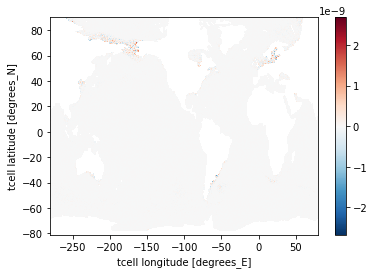

In [17]:
varc_des.mean('time').plot()

In [6]:
#var_paca=var_pac.resample(time='A').mean()
Clim_pac=var_pac.groupby('time.month').mean('time')
out_pac=var_pac.groupby('time.month')
varc_pac=(out_pac-Clim_pac) #Removing Climatology

In [23]:
#var_atla=var_atl.resample(time='A').mean()
Clim_atl=var_atl.groupby('time.month').mean('time')
out_atl=var_atl.groupby('time.month')
varc_atl=(out_atl-Clim_atl) #Removing Climatology

In [12]:
varc_pac=varc_pac.resample(time='A').mean()

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


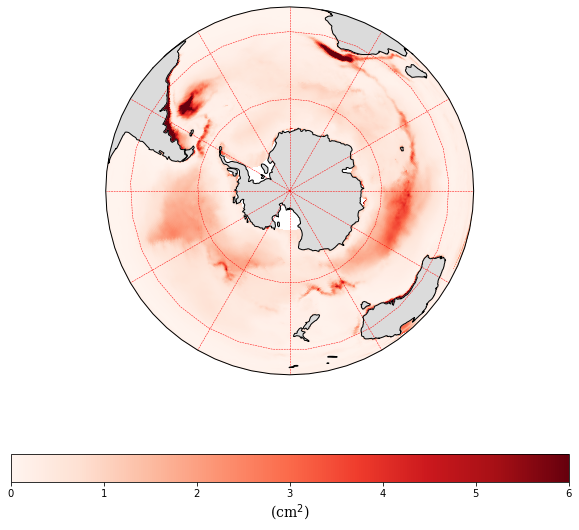

In [18]:
var_mean=var_sl.mean('time')
#y2 = np.log10(var_mean)
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cft
# create the figure panel 
fig = plt.figure(figsize=(10,10), facecolor='w')
# create the map using the cartopy Orthographic projection, selecting the South Pole
ax1 = plt.subplot(1,1,1, projection=ccrs.Orthographic(central_latitude=-90.0))
# add coastlines, gridlines, make sure the projection is maximised inside the plot, and fill in the land with colour
ax1.coastlines(resolution='110m', zorder=3) # zorder=3 makes sure that no other plots overlay the coastlines
ax1.gridlines(color='r', linestyle='--', linewidth=0.5,xlocs=np.arange(0,390,30),ylocs=np.arange(-90,90,30))
ax1.set_global()
ax1.add_feature(cft.LAND, zorder=1,facecolor=cft.COLORS['land_alt1'])
# plot mld field:
X,Y=np.meshgrid(var_sl.xt_ocean,var_sl.yt_ocean)
#ax1.set_yscale('log')
pp = plt.pcolormesh(X,Y,var_mean*1000,cmap='Reds', transform=ccrs.PlateCarree(),vmin=0,vmax=6)
#plt.contour(X,Y,mld_values_masked,color='k',levels=30, linewidth=0.1, transform=ccrs.PlateCarree())
fig.subplots_adjust(bottom=0.15)
#cbar_ax = fig.add_axes([0.2, 0.1, 0.625, 0.033])
cbar = plt.colorbar(pp, orientation='horizontal')
cbar.set_label(label='(cm$^{2}$)',size=14, family='serif')
# save the figure
fig.savefig('var_mean_14.png',dpi=300,bbox_inches='tight')

In [11]:
SSTm.load();

In [12]:
var_sl.load(); #Variance of sea level

In [45]:
#De-sesonalized the variable:
Clim_sl=var_sl.groupby('time.month').mean('time')
out_sl=var_sl.groupby('time.month')
var_des=(out_sl-Clim_sl) #Removing Climatology

# Nino 3.4 time series

In [12]:
# Load Nino 3.4 time series:
nino= SSTm.sel(xt_ocean=slice(-170,-120)).sel(yt_ocean=slice(-5,5))
SST_avg=nino.mean('xt_ocean').mean('yt_ocean')
Clim=SST_avg.groupby('time.month').mean('time')
out=SST_avg.groupby('time.month')
SSTa=(out-Clim)
#series=SSTa.to_pandas()
Nino_nor= (SSTa-np.mean(SSTa))/np.std(SSTa)
series=Nino_nor.to_dataframe()
df=series.drop('month', 1)

In [7]:
# Load SAM_cir time series:
slp_file = 'slp_40.nc'
slp1= xr.open_dataset(slp_file).psl
slp_40=slp1.sel(time=slice(aviso_clim_tstart,aviso_clim_tend))
slp2_file = 'slp_65.nc'
slp2= xr.open_dataset(slp2_file).psl
slp_65=slp2.sel(time=slice(aviso_clim_tstart,aviso_clim_tend))
slp_40nor = (slp_40-np.mean(slp_40))/np.std(slp_40)
slp_65nor = (slp_65-np.mean(slp_65))/np.std(slp_65)
sam_cir=(slp_40nor-slp_65nor)
sam_cir1=sam_cir.to_dataframe()
#sam_drop=sam_cir.drop(sam_cir.index[-2:])

In [8]:
sam_res=sam_cir.resample(time='A').mean()

In [13]:
var_paca

<xarray.DataArray (time: 168)>
dask.array<shape=(168,), dtype=float32, chunksize=(1,)>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-14T12:00:00 ... 2005-12-14T12:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [28]:
#sam_rolling=sam_cir.rolling(time=12).mean()

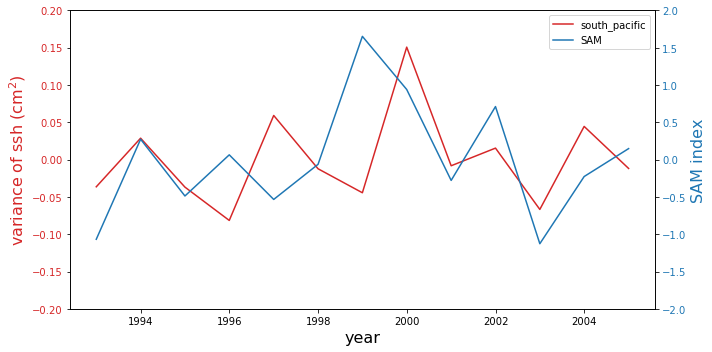

In [61]:
#fig = plt.figure(figsize=(20, 8))
fig,ax1 = plt.subplots(figsize=(10, 5))
color = 'tab:red'
ax1.set_xlabel('year',fontsize=16)
ax1.set_ylabel('variance of ssh (cm$^2$)',fontsize=16, color=color)
lns1=ax1.plot(var_paca.time,varc_pac*1000, color=color,label='south_pacific')
ax1.tick_params(axis='y', labelcolor=color)
#ax1.plot([pd.datetime(1991,1,1),pd.datetime(2006,1,1)],[0,0],'--k',linewidth=0.75)
#ax1.plot([0,0],'--k',linewidth=0.75)
ax1.set_ylim(-0.2, 0.2)
#plt.legend(['South_Pacific'], loc='upper right',fontsize=12)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('SAM index',fontsize=16, color=color)  # we already handled the x-label with ax1
lns2=ax2.plot(sam_res.time,sam_res, color=color,label='SAM')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-2, 2)
# Solution for having two legends
leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc=0)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
fig.savefig('var_pac_sam3.png',dpi=300,bbox_inches='tight')
#fig.savefig('seasonal_mean_eke_t1.png',dpi=300,bbox_inches='tight')

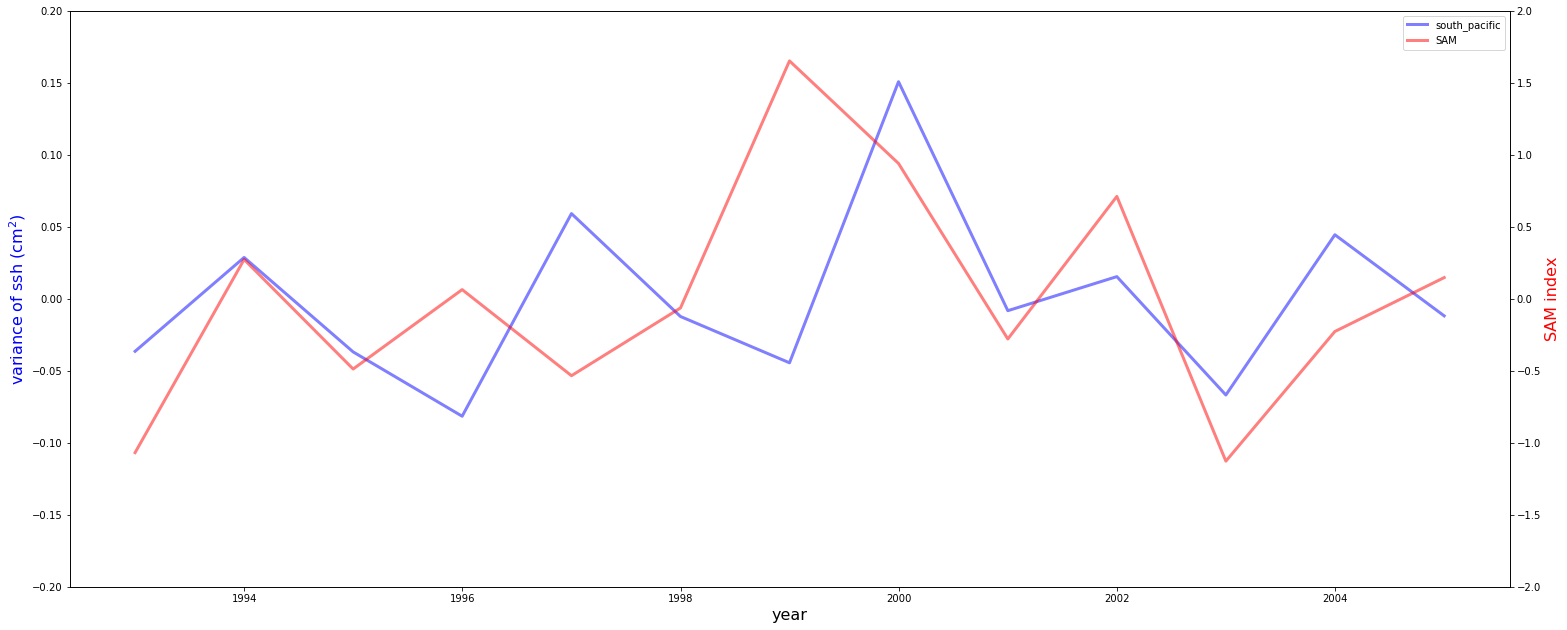

<Figure size 432x288 with 0 Axes>

In [57]:
# Plot two lines with different scales on the same plot
fig = plt.figure(figsize=(20, 8))
line_weight = 3
alpha = .5
ax1 = fig.add_axes([0, 0, 1, 1])
ax1.set_xlabel('year',fontsize=16)
ax1.set_ylabel('variance of ssh (cm$^2$)',fontsize=16, color='blue')
ax1.set_ylim(-0.2, 0.2)
ax2 = fig.add_axes()
# This is the magic that joins the x-axis
ax2 = ax1.twinx()
lns1 = ax1.plot(var_paca.time,varc_pac*1000, color='blue', lw=line_weight, alpha=alpha, label='south_pacific')
lns2 = ax2.plot(sam_res.time,sam_res, color='red', lw=line_weight, alpha=alpha, label='SAM')
ax2.set_ylabel('SAM index',fontsize=16, color='red') 
ax2.set_ylim(-2, 2)
# Solution for having two legends
leg = lns1 + lns2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc=0)
plt.show()
plt.savefig('var_pac_sam2.png')

In [ ]:
#JRA55_do Nino3.4
plt.figure(figsize=(20,8))
ax=plt.subplot(111)
plt.xlabel('year')
plt.ylabel('sst_anomaly')
ax.set_title('sst anomaly in Nino 3.4 region (5N-5S, 120-170W)',fontsize=17,color="red")
#ax.fill_between(sst_year, 0, obs_sst)
#ax.fill_between(SSTa.time,0, SSTa, where=SSTa>= 0, facecolor='red', interpolate=True)
#ax.fill_between(sst_year,0, SSTa, where=SSTa<= 0, facecolor='blue', interpolate=True)
ax.set_xlim([pd.datetime(1992,1,1),pd.datetime(2019,3,31)])
ax.plot([pd.datetime(1992,1,1),pd.datetime(2019,1,1)],[0,0],'k',linewidth=0.75)
ax.plot([pd.datetime(1992,1,1),pd.datetime(2019,1,1)],[0.5,0.5],'--k',linewidth=0.75)
ax.plot([pd.datetime(1992,1,1),pd.datetime(2019,1,1)],[-0.5,-0.5],'--k',linewidth=0.75)
#ax.set_xticks([pd.datetime(1994,1,1), pd.datetime(1998,1,1)], minor=True)
ax.set_xticks([pd.datetime(1993,1,1), pd.datetime(1994,1,1), pd.datetime(1995,1,1), pd.datetime(1997,1,1), 
               pd.datetime(1998,1,1), pd.datetime(1999,1,1), pd.datetime(2001,1,1), pd.datetime(2002,1,1), 
               pd.datetime(2003,1,1),  pd.datetime(2005,1,1), pd.datetime(2006,1,1), pd.datetime(2007,1,1),
               pd.datetime(2009,1,1),pd.datetime(2010,1,1),pd.datetime(2011,1,1),pd.datetime(2013,1,1),
               pd.datetime(2014,1,1),pd.datetime(2015,1,1),pd.datetime(2017,1,1),pd.datetime(2018,1,1),
               pd.datetime(2019,1,1)],minor=True)
ax.plot(SSTa.time,SSTa)
savefigure('sst anomaly in Nino 3.4 using JRA55')

In [46]:
#sstn=Nino_nor[3:178]
t=len(Nino_nor.time)
reg_sl= np.empty((t, 1080, 1440))
for i in range(1,t): # loop over time dimension
    reg_sl[i,:,:] = var_des[i,:,:] * Nino_nor[i] # regression here
    if i%80 == 0: # modulo function
        print(i) # print every 10th iteration
ds = xr.Dataset({ 'reg_sl': (('time', 'latitude', 'longitude'), reg_sl)})

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1,

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1,

80


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1,

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1,

160


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1,

In [18]:
ds.reg_sl

<xarray.DataArray 'reg_sl' (time: 60, latitude: 1080, longitude: 1440)>
array([[[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ...,
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Dimensions without coordinates: time, latitude, longitude

In [20]:
regsl_so=ds.reg_sl.sel(latitude=slice(-70,-20))

In [30]:
regsl_so

<xarray.DataArray 'reg_sl' (time: 60, latitude: 50, longitude: 1440)>
array([[[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ...,
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Dimensions without coordinates: time, latitude, longitude

In [47]:
reg_sl[i,:,:] = var_des[i,:,:] * Nino_nor[i]

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


 ...]

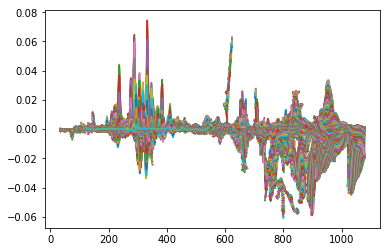

In [ ]:
time = Nino_nor.time
lat = var_des.yt_ocean
lon = var_des.xt_ocean

print(np.shape(reg_sl))
regsl_slope = xr.DataArray(
    np.zeros([np.shape(lat)[0], np.shape(lon)[0]]), 
    dims=('lat', 'lon'), 
    coords=[lat, lon], 
    name='regsl_slope')

regsl_p_value = xr.DataArray(
    np.zeros([np.shape(lat)[0], np.shape(lon)[0]]), 
    dims=('lat', 'lon'), 
    coords=[lat, lon], 
    name='regsl_p_value')
# slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
for iid, i in enumerate(lat):
    for jid, j in enumerate(lon):
        regsl_slope[iid, jid], _, _, regsl_p_value[iid, jid], _ = \
        stats.linregress(Nino_nor, var_des[:, iid, jid])
    print('lat ' + str(np.array(i)))
print(regsl_slope)


(168, 1080, 1440)


In [26]:
data = ds.reg_sl.mean('time')
data

<xarray.DataArray 'reg_sl' (latitude: 1080, longitude: 1440)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Dimensions without coordinates: latitude, longitude

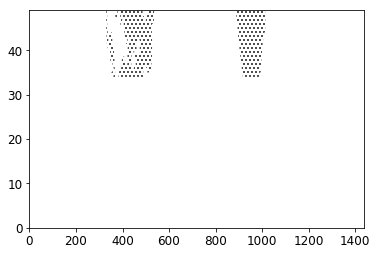

In [40]:
levels2=[0,0.6]
data2 = regsl_p_value
plot2 = plt.contourf(data2.lon, data2.lat, data2, hatches=['...'], colors='none', levels=levels2)

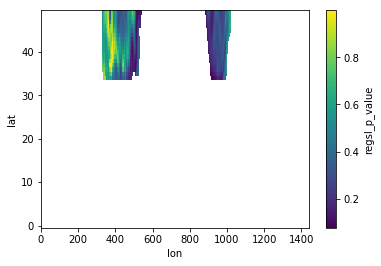

In [23]:
regsl_p_value.plot()

In [24]:
import cartopy.crs as ccrs
import cartopy.feature as cft
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

land_50m= cft.NaturalEarthFeature('physical', 'land', '110m',
                                    edgecolor='black',
                                    facecolor='white',
                                    linewidth=0.75)

import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(1, figsize=(6,6), facecolor=[0.98,0.98,0.98]) 
matplotlib.rcParams.update({'font.size': 12})

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
#levels=arange(-0.5,0.5,0.1)
cmap = plt.cm.RdBu_r
data = ds.reg_sl.mean('time')
plot = plt.pcolormesh(data.longitude, data.latitude, data, transform=ccrs.PlateCarree())

# levels2=[0, 0.05]
# data2 = sst_Aus_p_value
# plot2 = plt.contourf(data.lon, data.lat, data2, hatches=['...'],
#             colors='none', levels=levels2, transform=ccrs.PlateCarree())

# ax.set_title('a) 1982 to 2018 SST decadal trend', loc='left')

# ax.set_xticks(arange(80, 180, 20), crs=ccrs.PlateCarree())
# ax.set_yticks(arange(-70, 0, 20), crs=ccrs.PlateCarree())
# lon_formatter = LongitudeFormatter(zero_direction_label=True)
# lat_formatter = LatitudeFormatter()
# ax.xaxis.set_major_formatter(lon_formatter)
# ax.yaxis.set_major_formatter(lat_formatter)
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')


# ax.grid(linewidth=0.5, color='black', alpha=0.5, linestyle='--')
# ax.add_feature(land_50m)


# axins = inset_axes(ax,
#                    width="2%",  
#                    height="100%", 
#                    loc='lower left',
#                    bbox_to_anchor=(1.075, 0, 1, 1),
#                    bbox_transform=ax.transAxes,
#                    borderpad=0)
# cbar = plt.colorbar(plot, orientation='vertical',
#                     label=r'SST trend ($^{\circ}C \cdot 10\ yrs^{-1}$)', cax=axins)
# cbar.set_ticks(levels)

# savefigure('SST_trend')

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

distributed.nanny - WARNING - Worker process 22554 was killed by unknown signal
distributed.nanny - WARNING - Worker process 22556 was killed by unknown signal
distributed.nanny - WARNING - Worker process 22551 was killed by unknown signal
distributed.nanny - WARNING - Worker process 22548 was killed by unknown signal


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f45cd15a488> (for post_execute):


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


Error in callback <function flush_figures at 0x7f45e3a35d90> (for post_execute):


distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker


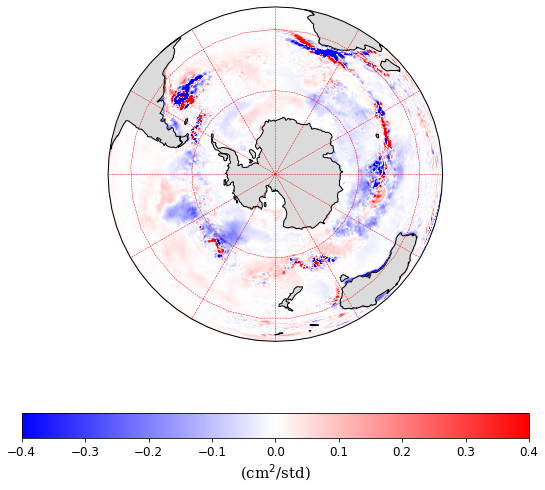

In [33]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
# create the figure panel 
fig = plt.figure(figsize=(20,20), facecolor='w')
data2 = regsl_p_value
levels2=[0, 0.5]
# create the map using the cartopy Orthographic projection, selecting the South Pole
ax1 = plt.subplot(2,2,1, projection=ccrs.Orthographic(central_latitude=-90.0))
# add coastlines, gridlines, make sure the projection is maximised inside the plot, and fill in the land with colour
for ax in [ax1]:
        ax.coastlines(resolution='110m',zorder=3)
        #ax.stock_img()
        ax.gridlines(color='r', linestyle='--', linewidth=0.5,xlocs=np.arange(0,390,30),ylocs=np.arange(-90,90,30))
        ax.set_global()
        pp1 = plt.contourf(data2.lon, data2.lat, data2, hatches=['...'],colors='none',levels=levels2, transform=ccrs.PlateCarree())
        ax.add_feature(cft.LAND, zorder=1,facecolor=cft.COLORS['land_alt1'])
        X,Y=np.meshgrid(var_des.xt_ocean,var_des.yt_ocean)
        pp=ax1.pcolormesh(X,Y,data*1000,cmap='bwr',vmin=-0.4,vmax=0.4,transform=ccrs.PlateCarree())
        #ax1.set_title('No lag')
        
fig.subplots_adjust(bottom=0.15)
#cbar_ax = fig.add_axes([0.2, 0.1, 0.625, 0.033])
#cbar = plt.colorbar(pp, cax=cbar_ax, orientation='horizontal')
cbar = plt.colorbar(pp, orientation='horizontal')
cbar.set_label(label='(cm$^{2}$/std)',size=15, family='serif')
#fig.savefig('reg_sam_lag_1992-2004_correct.png',dpi=300,bbox_inches='tight')

In [ ]:
n=len(var_des.yt_ocean)
m=len(var_des.xt_ocean)
error = np.empty((t, 1080, 1440))
SE =np.empty((1080,1440))
rms=np.empty((1080,1440))
for i in range(1,t): # loop over time dimension
    error[i,:,:] = var_des[i,:,:] - np.dot(reg_sl[i,:,:],sstn[i]) # regression here
    if i%100 == 0: # modulo function
        print(i) # print every 10th iteration
de= xr.Dataset({ 'error': (('time', 'latitude', 'longitude'), error)})
for i in range(1,n):
    for j in range(1,m): #loop over lat and lon
        SE[i,j] = ((np.var(error[:,i,j],axis=0))/sqrt(t-1))
        rms[i,j]=np.sqrt(SE[i,j])
    if i%100 == 0:# modulo function
        if j%100 == 0:# modulo function
            print(i,j) 
dse= xr.Dataset({'SE': (('latitude', 'longitude'), SE),'rms': (('latitude','longitude'),rms)})

In [ ]:
#Significance criteria:
reg_abs=abs(ds.reg_sl[:,:])
se =2**dse.rms[:,:]
if reg_abs> se:
    print('Data is significant')
    plt.contourf(x, y, p_pre[240,:,:], levels=levels, hatches=["", "."], alpha=0)
elif reg_abs< se:
   print('Data is not significant')
else:
   print('Do with other dataset')

In [37]:
#Lagged-Regression:
lag =36; #in terms of months
Nino_nor_lag=df.shift(periods=lag, fill_value=0)
#sam_lag=sam_drop.shift(periods=lag, fill_value=0)
sam_lag=sam_cir1.shift(periods=lag, fill_value=0)
#sampac_lag=sam_p.shift(periods=lag,fill_value=0)
if lag<0:
    Nino_lag=Nino_nor_lag.drop(Nino_nor_lag.index[lag:])
    samc_lag=sam_lag.drop(sam_lag.index[lag:])
    #samp_lag=sampac_lag.drop(sampac_lag.index[lag:])
    #SSTm_mod=SSTm[:lag,:,:]
    var_mod_pac=varc_pac[:lag,:,:] #Variance after lag regression
    var_mod_atl=varc_atl[:lag,:,:] 
elif lag>0:
    Nino_lag=Nino_nor_lag.drop(Nino_nor_lag.index[:lag])
    samc_lag=sam_lag.drop(sam_lag.index[:lag])
    #samp_lag=sampac_lag.drop(sampac_lag.index[:lag])
    #SSTm_mod=SSTm[lag:,:,:]
    var_mod_pac=varc_pac[lag:,:,:]
    var_mod_atl=varc_atl[lag:,:,:]
else:
    Nino_lag = Nino_nor_lag
    #SSTm_mod = SSTm
    var_mod_pac = varc_pac
    var_mod_atl = varc_atl
    samc_lag=sam_lag
    #samp_lag=sampac_lag

In [28]:
samc_lag

,psl
time,
1992-01-31,-0.532461
1992-02-29,-1.444925
1992-03-31,-0.520468
1992-04-30,-0.316205
1992-05-31,-3.392391
1992-06-30,-4.948243
1992-07-31,-0.514560
1992-08-31,-0.367276
1992-09-30,0.380758


In [29]:
tl=len(var_mod_pac.time)
# SAM_Cir regressed Variance of sl with 0 year lag
regsc_lag0=np.dot(np.transpose(samc_lag),np.transpose(var_mod_pac.values,(1,0,2)))/tl
#reg_nino0= np.dot(np.transpose(Nino_lag),np.transpose(var_mod.values,(1,0,2)))/tl
regsc0=np.squeeze(regsc_lag0)
#reg1=np.squeeze(reg_nino1)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [31]:
tl=len(var_mod_pac.time)
# SAM_Cir regressed Variance of sl with 6 month lag
regsc_lag6m=np.dot(np.transpose(samc_lag),np.transpose(var_mod_pac.values,(1,0,2)))/tl
#reg_nino0= np.dot(np.transpose(Nino_lag),np.transpose(var_mod.values,(1,0,2)))/tl
regsc6m=np.squeeze(regsc_lag6m)
#reg1=np.squeeze(reg_nino1)

In [34]:
tl=len(var_mod_pac.time)
# SAM_Cir regressed Variance of sl with 1 year lag
regsc_lag1=np.dot(np.transpose(samc_lag),np.transpose(var_mod_pac.values,(1,0,2)))/tl
#reg_nino1= np.dot(np.transpose(Nino_lag),np.transpose(var_mod.values,(1,0,2)))/tl
regsc1=np.squeeze(regsc_lag1)
#reg1=np.squeeze(reg_nino1)

In [36]:
tl=len(var_mod_pac.time)
# SAM_Cir regressed Variance of sl with 2 year lag
regsc_lag2=np.dot(np.transpose(samc_lag),np.transpose(var_mod_pac.values,(1,0,2)))/tl
#reg_nino1= np.dot(np.transpose(Nino_lag),np.transpose(var_mod.values,(1,0,2)))/tl
regsc2=np.squeeze(regsc_lag2)
#reg1=np.squeeze(reg_nino1)

In [38]:
tl=len(var_mod_pac.time)
# SAM_Cir regressed Variance of sl with 3 year lag
regsc_lag3=np.dot(np.transpose(samc_lag),np.transpose(var_mod_pac.values,(1,0,2)))/tl
#reg_nino1= np.dot(np.transpose(Nino_lag),np.transpose(var_mod.values,(1,0,2)))/tl
regsc3=np.squeeze(regsc_lag3)
#reg1=np.squeeze(reg_nino1)

In [43]:
regsc6m.shape

(100, 540)

In [ ]:
import regionmask
fig = plt.figure(figsize=(10, 13))
cf = plt.pcolormesh(lat,EKE_xavg.month,EKE_nor,cmap='RdBu',vmin=-0.0025,vmax=0.0025)
#cf = plt.contour(lat,EKE_xavg.month,EKE_anom_xavg,color='k', vmin=0.01,vmax=0.06
cbar = plt.colorbar(cf, orientation='vertical')
#lat_m=lat[1050:1450]
#mask = regionmask.defined_regions.srex.mask(lat_m, xarray=False)
#mask_ma = np.ma.masked_invalid(mask)
h = plt.pcolormesh(lon, lat, mask_ma)
labels = ['Jan', 'Feb','Mar','Apr','May','Jun','July','Aug','Sept','Oct','Nov','Dec']
plt.yticks(EKE_xavg.month,labels, rotation='vertical')
plt.ylabel('Months')
plt.xlabel('latitude(degrees)')
cbar.set_label('EKE(m$^{2}$/s$^{2}$)')
plt.title('Hovmoller Diagram')
plt.savefig('EKE_mean_anom_nor3.png')

In [29]:
#Lagged-Regression:
lag =36; #in terms of months
Nino_nor_lag=df.shift(periods=lag, fill_value=0)
#sam_lag=sam_drop.shift(periods=lag, fill_value=0)
sam_lag=sam_cir1.shift(periods=lag, fill_value=0)
#sampac_lag=sam_p.shift(periods=lag,fill_value=0)
if lag<0:
    Nino_lag=Nino_nor_lag.drop(Nino_nor_lag.index[lag:])
    samc_lag=sam_lag.drop(sam_lag.index[lag:])
    #samp_lag=sampac_lag.drop(sampac_lag.index[lag:])
    #SSTm_mod=SSTm[:lag,:,:]
    var_mod=var_des[:lag,:,:]    #Variance after lag regression
elif lag>0:
    Nino_lag=Nino_nor_lag.drop(Nino_nor_lag.index[:lag])
    samc_lag=sam_lag.drop(sam_lag.index[:lag])
    #samp_lag=sampac_lag.drop(sampac_lag.index[:lag])
    #SSTm_mod=SSTm[lag:,:,:]
    var_mod=var_des[lag:,:,:]
else:
    Nino_lag = Nino_nor_lag
    #SSTm_mod = SSTm
    var_mod = var_des
    samc_lag=sam_lag
    #samp_lag=sampac_lag

In [27]:
samc_lag

,psl
time,
1994-01-31,-0.568176
1994-02-28,-1.477702
1994-03-31,-0.549987
1994-04-30,-0.346412
1994-05-31,-3.417888
1994-06-30,-4.972911
1994-07-31,-0.539622
1994-08-31,-0.390535
1994-09-30,0.355029


In [25]:
tl=len(var_mod.time)
# SAM_Cir regressed Variance of sl with 1 year lag
regsc_lag1=np.dot(np.transpose(samc_lag),np.transpose(var_mod.values,(1,0,2)))/tl
reg_nino1= np.dot(np.transpose(Nino_lag),np.transpose(var_mod.values,(1,0,2)))/tl
regsc1=np.squeeze(regsc_lag1)
reg1=np.squeeze(reg_nino1)

In [28]:
tl=len(var_mod.time)
# SAM_Cir regressed Variance of sl with 2 year lag
regsc_lag2=np.dot(np.transpose(samc_lag),np.transpose(var_mod.values,(1,0,2)))/tl
reg_nino2= np.dot(np.transpose(Nino_lag),np.transpose(var_mod.values,(1,0,2)))/tl
regsc2=np.squeeze(regsc_lag2)
reg2=np.squeeze(reg_nino2)

In [10]:
tl=len(var_mod.time)
# SAM_Cir regressed Variance of sl with 2 year lag
regsc_lag0=np.dot(np.transpose(samc_lag),np.transpose(var_mod.values,(1,0,2)))/tl
reg_nino0= np.dot(np.transpose(Nino_lag),np.transpose(var_mod.values,(1,0,2)))/tl
regsc0=np.squeeze(regsc_lag0)
reg0=np.squeeze(reg_nino0)

In [30]:
tl=len(var_mod.time)
# SAM_Cir regressed Variance of sl with 2 year lag
regsc_lag3=np.dot(np.transpose(samc_lag),np.transpose(var_mod.values,(1,0,2)))/tl
reg_nino3= np.dot(np.transpose(Nino_lag),np.transpose(var_mod.values,(1,0,2)))/tl
regsc3=np.squeeze(regsc_lag3)
reg3=np.squeeze(reg_nino3)

In [40]:
tl=len(var_mod.time)
# SAM_Cir regressed Variance of sl with 2 year lag
regsc_lag2b=np.dot(np.transpose(samc_lag),np.transpose(var_mod.values,(1,0,2)))/tl
reg_nino2b= np.dot(np.transpose(Nino_lag),np.transpose(var_mod.values,(1,0,2)))/tl
regsc2b=np.squeeze(regsc_lag2b)

In [21]:
# SAM_Cir regressed Variance of sl with 4 year lag
regsc_lag4=np.dot(np.transpose(samc_lag),np.transpose(var_mod.values,(1,0,2)))/tl
reg_nino4= np.dot(np.transpose(Nino_lag),np.transpose(var_mod.values,(1,0,2)))/tl
regsc4=np.squeeze(regsc_lag4)
regsc4=np.squeeze(regsc_lag4)

In [12]:
tl=len(var_mod.time)
# SAM_Cir regressed Variance of sl with 2 year lag
regsc_lag6=np.dot(np.transpose(samc_lag),np.transpose(var_mod.values,(1,0,2)))/tl
reg_nino6= np.dot(np.transpose(Nino_lag),np.transpose(var_mod.values,(1,0,2)))/tl
regsc6=np.squeeze(regsc_lag6)
reg6=np.squeeze(reg_nino6)

In [14]:
tl=len(var_mod.time)
# SAM_Cir regressed Variance of sl with 2 year lag
regsc_lag8=np.dot(np.transpose(samc_lag),np.transpose(var_mod.values,(1,0,2)))/tl
reg_nino8= np.dot(np.transpose(Nino_lag),np.transpose(var_mod.values,(1,0,2)))/tl
regsc8=np.squeeze(regsc_lag8)
reg8=np.squeeze(reg_nino8)

In [43]:
regsc_lag4b=np.dot(np.transpose(samc_lag),np.transpose(var_mod.values,(1,0,2)))/tl
reg_nino4b= np.dot(np.transpose(Nino_lag),np.transpose(var_mod.values,(1,0,2)))/tl
regsc4b=np.squeeze(regsc_lag4b)

In [18]:
# SAM_Cir regressed Variance of sl with 0 year lag
regsc_lag0=np.dot(np.transpose(samc_lag),np.transpose(var_mod.values,(1,0,2)))/tl
reg_nino0= np.dot(np.transpose(Nino_lag),np.transpose(var_mod.values,(1,0,2)))/tl
regsc0=np.squeeze(regsc_lag0)

In [45]:
#forward
reg0=np.squeeze(reg_nino0)
reg2=np.squeeze(reg_nino2)
reg3=np.squeeze(reg_nino3)
reg4=np.squeeze(reg_nino4)
#backward
reg2b=np.squeeze(reg_nino2b)
reg3b=np.squeeze(reg_nino3b)
reg4b=np.squeeze(reg_nino4b)

In [27]:
# SAM_Cir regressed Variance of sl with 3 year lag
regsc_lag3=np.dot(np.transpose(samc_lag),np.transpose(var_mod.values,(1,0,2)))/tl
reg_nino3= np.dot(np.transpose(Nino_lag),np.transpose(var_mod.values,(1,0,2)))/tl
regsc3=np.squeeze(regsc_lag3)

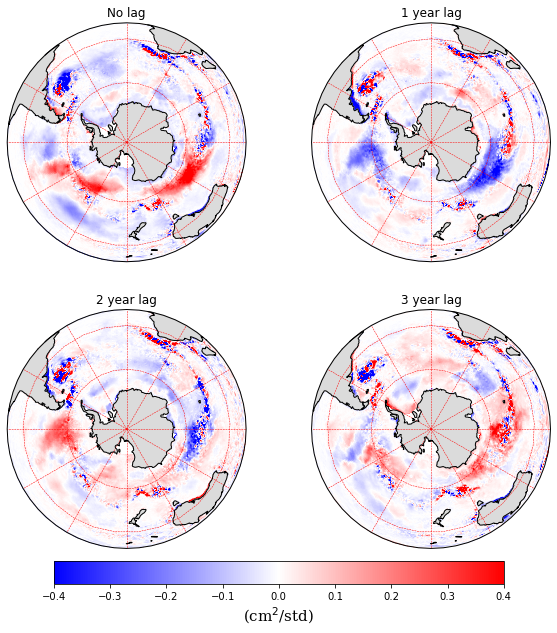

In [31]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
# create the figure panel 
fig = plt.figure(figsize=(10,10), facecolor='w')
# create the map using the cartopy Orthographic projection, selecting the South Pole
ax1 = plt.subplot(2,2,1, projection=ccrs.Orthographic(central_latitude=-90.0))
ax2 = plt.subplot(2,2,2, projection=ccrs.Orthographic(central_latitude=-90.0))
ax3 = plt.subplot(2,2,3 , projection=ccrs.Orthographic(central_latitude=-90.0))
ax4 = plt.subplot(2,2,4, projection=ccrs.Orthographic(central_latitude=-90.0))
# add coastlines, gridlines, make sure the projection is maximised inside the plot, and fill in the land with colour
for ax in [ax1, ax2, ax3, ax4]:
        ax.coastlines(resolution='110m',zorder=3)
        #ax.stock_img()
        ax.gridlines(color='r', linestyle='--', linewidth=0.5,xlocs=np.arange(0,390,30),ylocs=np.arange(-90,90,30))
        ax.set_global()
        ax.add_feature(cft.LAND, zorder=1,facecolor=cft.COLORS['land_alt1'])
        X,Y=np.meshgrid(var_des.xt_ocean,var_des.yt_ocean)
        pp=ax1.pcolormesh(X,Y,regsc0*1000,cmap='bwr',vmin=-0.4,vmax=0.4,transform=ccrs.PlateCarree())
        ax1.set_title('No lag')
        ax2.pcolormesh(X,Y,regsc1*1000,cmap='bwr',vmin=-0.4,vmax=0.4,transform=ccrs.PlateCarree())
        ax2.set_title('1 year lag')
        ax3.pcolormesh(X,Y,regsc2*1000,cmap='bwr',vmin=-0.4,vmax=0.4,transform=ccrs.PlateCarree())
        ax3.set_title('2 year lag')
        ax4.pcolormesh(X,Y,regsc3*1000,cmap='bwr',vmin=-0.4,vmax=0.4,transform=ccrs.PlateCarree())
        ax4.set_title('3 year lag')
        
fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.2, 0.1, 0.625, 0.033])
cbar = plt.colorbar(pp, cax=cbar_ax, orientation='horizontal')
cbar.set_label(label='(cm$^{2}$/std)',size=15, family='serif')
fig.savefig('reg_sam_lag_1992-2004_correct.png',dpi=300,bbox_inches='tight')

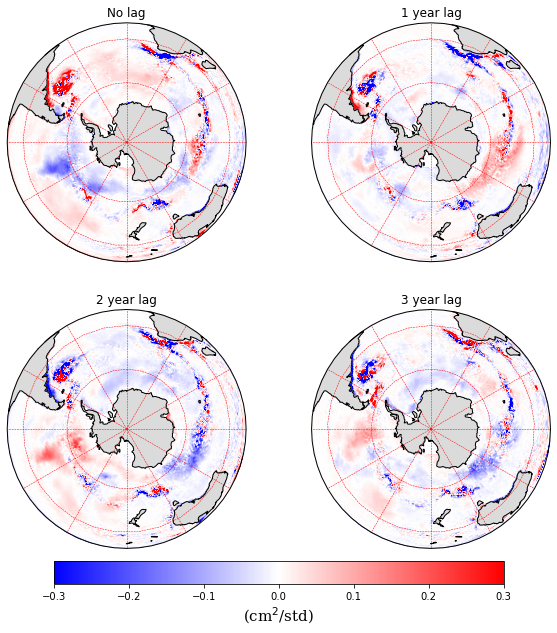

In [32]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
# create the figure panel 
fig = plt.figure(figsize=(10,10), facecolor='w')
# create the map using the cartopy Orthographic projection, selecting the South Pole
ax1 = plt.subplot(2,2,1, projection=ccrs.Orthographic(central_latitude=-90.0))
ax2 = plt.subplot(2,2,2, projection=ccrs.Orthographic(central_latitude=-90.0))
ax3 = plt.subplot(2,2,3 , projection=ccrs.Orthographic(central_latitude=-90.0))
ax4 = plt.subplot(2,2,4, projection=ccrs.Orthographic(central_latitude=-90.0))
# add coastlines, gridlines, make sure the projection is maximised inside the plot, and fill in the land with colour
for ax in [ax1, ax2, ax3, ax4]:
        ax.coastlines(resolution='110m',zorder=3)
        #ax.stock_img()
        ax.gridlines(color='r', linestyle='--', linewidth=0.5,xlocs=np.arange(0,390,30),ylocs=np.arange(-90,90,30))
        ax.set_global()
        ax.add_feature(cft.LAND, zorder=1,facecolor=cft.COLORS['land_alt1'])
        X,Y=np.meshgrid(var_des.xt_ocean,var_des.yt_ocean)
        pp=ax1.pcolormesh(X,Y,reg0*1000,cmap='bwr',vmin=-0.3,vmax=0.3,transform=ccrs.PlateCarree())
        ax1.set_title('No lag')
        ax2.pcolormesh(X,Y,reg1*1000,cmap='bwr',vmin=-0.3,vmax=0.3,transform=ccrs.PlateCarree())
        ax2.set_title('1 year lag')
        ax3.pcolormesh(X,Y,reg2*1000,cmap='bwr',vmin=-0.3,vmax=0.3,transform=ccrs.PlateCarree())
        ax3.set_title('2 year lag')
        ax4.pcolormesh(X,Y,reg3*1000,cmap='bwr',vmin=-0.3,vmax=0.3,transform=ccrs.PlateCarree())
        ax4.set_title('3 year lag')
        
fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.2, 0.1, 0.625, 0.033])
cbar = plt.colorbar(pp, cax=cbar_ax, orientation='horizontal')
cbar.set_label(label='(cm$^{2}$/std)',size=15, family='serif')
fig.savefig('reg_nino_lag_1992-2004_correct.png',dpi=300,bbox_inches='tight')

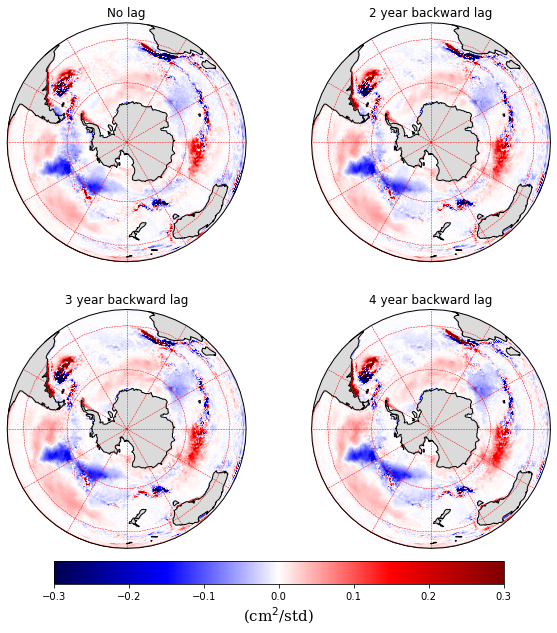

In [46]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
# create the figure panel 
fig = plt.figure(figsize=(10,10), facecolor='w')
# create the map using the cartopy Orthographic projection, selecting the South Pole
ax1 = plt.subplot(2,2,1, projection=ccrs.Orthographic(central_latitude=-90.0))
ax2 = plt.subplot(2,2,2, projection=ccrs.Orthographic(central_latitude=-90.0))
ax3 = plt.subplot(2,2,3 , projection=ccrs.Orthographic(central_latitude=-90.0))
ax4 = plt.subplot(2,2,4, projection=ccrs.Orthographic(central_latitude=-90.0))
# add coastlines, gridlines, make sure the projection is maximised inside the plot, and fill in the land with colour
for ax in [ax1, ax2, ax3, ax4]:
        ax.coastlines(resolution='110m',zorder=3)
        #ax.stock_img()
        ax.gridlines(color='r', linestyle='--', linewidth=0.5,xlocs=np.arange(0,390,30),ylocs=np.arange(-90,90,30))
        ax.set_global()
        ax.add_feature(cft.LAND, zorder=1,facecolor=cft.COLORS['land_alt1'])
        X,Y=np.meshgrid(var_des.xt_ocean,var_des.yt_ocean)
        pp=ax1.pcolormesh(X,Y,reg0*1000,cmap='seismic',vmin=-0.3,vmax=0.3,transform=ccrs.PlateCarree())
        ax1.set_title('No lag')
        ax2.pcolormesh(X,Y,reg2b*1000,cmap='seismic',vmin=-0.3,vmax=0.3,transform=ccrs.PlateCarree())
        ax2.set_title('2 year backward lag')
        ax3.pcolormesh(X,Y,reg3b*1000,cmap='seismic',vmin=-0.3,vmax=0.3,transform=ccrs.PlateCarree())
        ax3.set_title('3 year backward lag')
        ax4.pcolormesh(X,Y,reg4b*1000,cmap='seismic',vmin=-0.3,vmax=0.3,transform=ccrs.PlateCarree())
        ax4.set_title('4 year backward lag')
        
fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.2, 0.1, 0.625, 0.033])
cbar = plt.colorbar(pp, cax=cbar_ax, orientation='horizontal')
cbar.set_label(label='(cm$^{2}$/std)',size=15, family='serif')
fig.savefig('reg_nino_bac_lag.png',dpi=300,bbox_inches='tight')

In [ ]:
#plt.figure(figsize(10,10))
land_50m = cft.NaturalEarthFeature('physical', 'land', '110m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=0.5)
ax = plt.subplot(1,1,1,projection=ccrs.SouthPolarStereo())
ax.add_feature(land_50m)
ax.set_extent([-280, 80 , -90, -20], crs=ccrs.PlateCarree())
#gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
#gl.xlocator = mticker.FixedLocator([-240, -180, -120, -60, 0, 60])
#gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50])
gl.xlabels_top = False
gl.ylabels_right = False
X,Y=np.meshgrid(var_des.xt_ocean,var_des.yt_ocean)
h=plt.pcolormesh(X,Y,regsc*1000.,cmap='RdBu_r',vmax=0.25,vmin=-0.25,transform=ccrs.PlateCarree())    
cb = plt.colorbar(h,orientation='vertical',label='cm2/std')
plt.title('JRA55-do SAM_Circumplor regressed variance of sea_level_lag=6')
savefigure('SAM_cir Regressed variance of sea_level_6')
#p1=plt.pcolormesh(SSTm,cmap='RdBu_r',transform=ccrs.PlateCarree()) 
#p1.cmap.set_over(color=cmp(255), alpha=None)
#gyre_psi.plot.contour(levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
#gyre_psi.plot.contour(levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
#plt.title(plot_labels[i]+exptdata.exptdict[ekey]['desc'])

In [ ]:
tl=len(var_mod.time)
# SAM_Cir regressed Variance of sl
regsp_lag=np.dot(np.transpose(samp_lag),np.transpose(var_mod.values,(1,0,2)))/tl
regsp=np.squeeze(regsp_lag)
#reg_cir.shape
#regression Plot
plt.figure(figsize=(15,8))
X,Y=np.meshgrid(var_des.xt_ocean,var_des.yt_ocean)
h=plt.pcolormesh(X,Y,regsp*1000.,cmap='RdBu_r',vmax=0.25,vmin=-0.25)
cb = plt.colorbar(h,orientation='vertical',label='cm2/std')
#plt.contour(X,Y,reg,levels=5, linewidths=0.5, colors='k')
plt.title('JRA55-do SAM_pacific regressed variance of sea_level_lag=5')
plt.ylabel('latitude(degrees)')
plt.xlabel('longitude(degrees)')
savefigure('SAM_cir Regressed variance of sea_level_5')

In [13]:
#Lag_Regression_variance of sea_level
tl=len(var_mod.time)
regv_lag=np.dot(np.transpose((Nino_lag)),np.transpose((var_mod-var_mod.mean('time')).values,(1,0,2)))/tl
regv=np.squeeze(regv_lag)
#Regression plot
plt.figure(figsize=(15,8))
X,Y=np.meshgrid(var_des.xt_ocean,var_des.yt_ocean)
h=plt.pcolormesh(X,Y,regv*1000.,cmap='RdBu_r',vmax=0.07,vmin=-0.07)
cb = plt.colorbar(h,orientation='vertical',label='cm2/std')
plt.contour(X,Y,regv*1000,levels=20, linewidths=0.5, colors='k')
plt.title('JRA55-do Nino 3.4 regressed variance of sea_level (lag=0)')
plt.ylabel('latitude(degrees)')
plt.xlabel('longitude(degrees)')
savefigure('lag_Reg variance of sea_level_0')

MemoryError: 

Text(0.5, 0, 'longitude(degrees)')

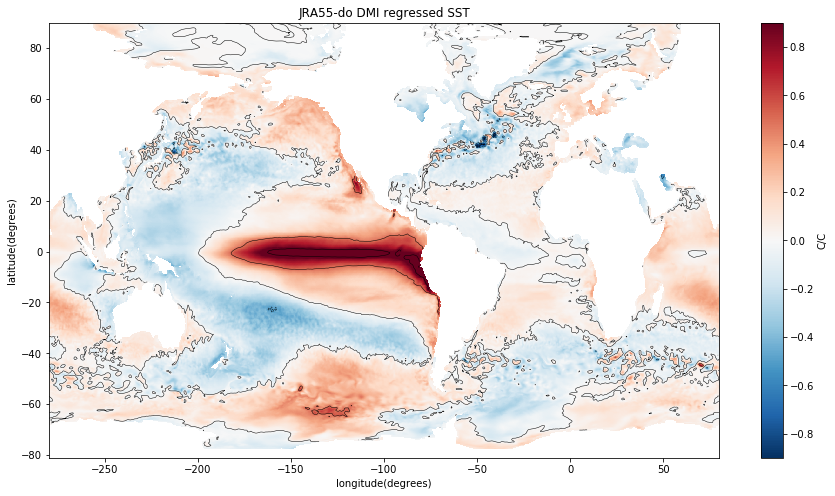

In [24]:
tl=len(SSTm.time)
#Calculate Nino 3.4 regressed sea surface temprature:
reg_sst=np.dot(Nino_nor,np.transpose(SSTm.values,(1,0,2)))/tl
#Regression plot
plt.figure(figsize=(15,8))
X,Y=np.meshgrid(SSTm.xt_ocean,SSTm.yt_ocean)
h=plt.pcolormesh(X,Y,reg_sst,cmap='RdBu_r',vmax=0.9,vmin=-0.9)
cb = plt.colorbar(h,orientation='vertical',label='C/C')
plt.contour(X,Y,reg_sst,levels=5, linewidths=0.5, colors='k')
plt.title('JRA55-do DMI regressed SST')
plt.ylabel('latitude(degrees)')
plt.xlabel('longitude(degrees)')
#savefigure('Regressed sst with IOD')

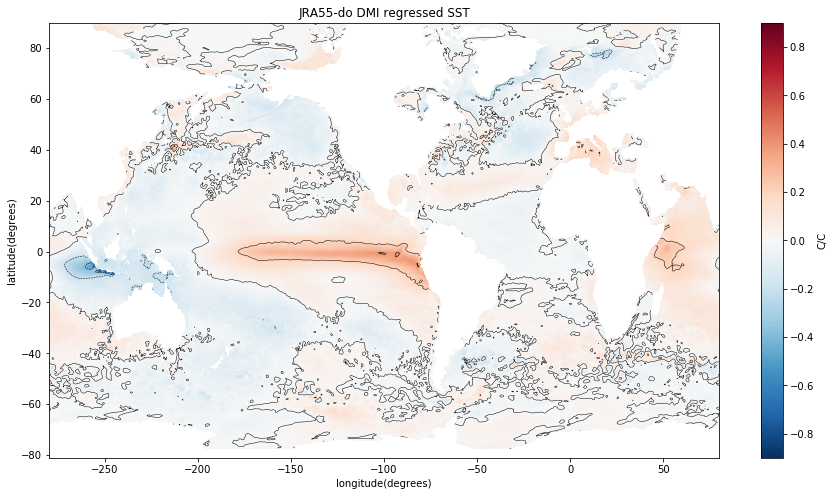

In [18]:
tl=len(SSTm.time)
#Calculate Nino 3.4 regressed sea surface temprature:
reg_sst=np.dot(DMI_nor,np.transpose(SSTm.values,(1,0,2)))/tl
#Regression plot
plt.figure(figsize=(15,8))
X,Y=np.meshgrid(SSTm.xt_ocean,SSTm.yt_ocean)
h=plt.pcolormesh(X,Y,reg_sst,cmap='RdBu_r',vmax=0.9,vmin=-0.9)
cb = plt.colorbar(h,orientation='vertical',label='C/C')
plt.contour(X,Y,reg_sst,levels=5, linewidths=0.5, colors='k')
plt.title('JRA55-do DMI regressed SST')
plt.ylabel('latitude(degrees)')
plt.xlabel('longitude(degrees)')
savefigure('Regressed sst with IOD')

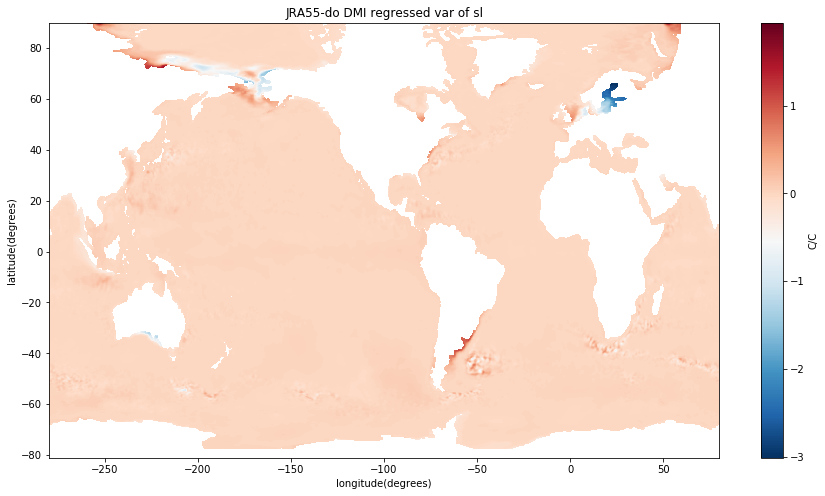

In [13]:
tl=len(var_des.time)
#Calculate Nino 3.4 regressed sea surface temprature:
reg_dmi=np.dot(DMI_nor,np.transpose(var_des.values,(1,0,2)))/tl
#Regression plot
plt.figure(figsize=(15,8))
X,Y=np.meshgrid(SSTm.xt_ocean,SSTm.yt_ocean)
h=plt.pcolormesh(X,Y,reg_dmi*1000,cmap='RdBu_r',vmax=0.9,vmin=-0.9)
cb = plt.colorbar(h,orientation='vertical',label='C/C')
#plt.contour(X,Y,reg_dmi*1000,levels=5, linewidths=0.5, colors='k')
plt.title('JRA55-do DMI regressed var of sl')
plt.ylabel('latitude(degrees)')
plt.xlabel('longitude(degrees)')
savefigure('Regressed sl with IOD')

In [ ]:
sam=sam_drop.to_xarray()
sam=sam.to_array()
tl=len(var_des.time)
#var_mean= var_des-var_des.mean('time')
# SAM_Cir regressed Variance of sl
reg_cir1=np.dot(sam,np.transpose(var_des.values,(1,0,2)))/tl
reg_cir=np.squeeze(reg_cir1)
reg_cir.shape
#regression Plot
plt.figure(figsize=(15,8))
X,Y=np.meshgrid(var_des.xt_ocean,var_des.yt_ocean)
h=plt.pcolormesh(X,Y,reg_cir*1000.,cmap='RdBu_r',vmax=0.25,vmin=-0.25)
cb = plt.colorbar(h,orientation='vertical',label='cm2/std')
#plt.contour(X,Y,reg,levels=5, linewidths=0.5, colors='k')
plt.title('JRA55-do SAM_Circumplor regressed variance of sea_level')
plt.ylabel('latitude(degrees)')
plt.xlabel('longitude(degrees)')
savefigure('SAM_cir Regressed variance of sea_level-025')

In [ ]:
test,pvalue2=scipy.stats.ttest_ind(sam_drop,var_des,axis=0,equal_var=False)
plt.figure(figsize=(15,8))
X,Y=np.meshgrid(SSTm.xt_ocean,SSTm.yt_ocean)
h=plt.pcolormesh(X,Y,pvalue2,cmap='RdBu_r')#,vmax=0.2,vmin=-0.2)
cb = plt.colorbar(h,orientation='vertical')
#plt.contour(X,Y,reg,levels=10, linewidths=0.5, colors='k')
#plt.title('JRA55-do Nino 3.4 regressed SST')
plt.ylabel('latitude(degrees)')
plt.xlabel('longitude(degrees)')
#savefigure('Regressed sst_30y_1')

In [ ]:
# SAM_Pac regressed Variance of sl
reg_pac=np.dot(sam_pac.values,np.transpose(var_des.values,(1,0,2)))/tl
reg1_pac=np.squeeze(reg_pac)
#regression Plot
plt.figure(figsize=(15,8))
X,Y=np.meshgrid(var_des.xt_ocean,var_des.yt_ocean)
h=plt.pcolormesh(X,Y,reg1_pac*1000.,cmap='RdBu_r',vmax=0.25,vmin=-0.25)
cb = plt.colorbar(h,orientation='vertical',label='cm2/std')
#plt.contour(X,Y,reg,levels=5, linewidths=0.5, colors='k')
plt.title('JRA55-do SAM_Pacific regressed variance of sea_level')
plt.ylabel('latitude(degrees)')
plt.xlabel('longitude(degrees)')
savefigure('SAM_pacific Regressed variance of sea_level-025_30year')

In [ ]:
len(SSTnortime)

In [ ]:
tl=len(SSTm.time)
# Calculate Nino 3.4 normalized trend:
reg=np.dot(SSTnortime,np.transpose(SST.values,(1,0,2)))/tl/tl/tl

In [ ]:
trend = 3.*SSTnortime

In [ ]:
reg = np.dot(SSTnortime,trend-np.mean(trend))/tl

In [ ]:
SSTnortime = SSTnor.time.values.astype('datetime64[Y]').astype('float64')*12.+SSTnor.time.values.astype('datetime64[M]').astype('float64')
SSTnortime = (SSTnortime-SSTnortime.mean())/SSTnortime.std()

In [ ]:
SSTts = trend
plt.plot(SSTts)
plt.plot(reg*SSTnortime+2.)

In [ ]:
SSTnortime

In [ ]:
SSTnortime

In [ ]:
tl=len(var_trend.time)
tl

In [ ]:
#Calculate Nino 3.4 regressed variance of Sea_level:
reg=np.dot(SSTnor,np.transpose(var_trend.values,(1,0,2)))/tl

In [ ]:
reg

In [ ]:
plt.figure(figsize=(15,8))
X,Y=np.meshgrid(var_sl.xt_ocean,var_sl.yt_ocean)
#h=plt.contourf(X,Y,reg,levels=250,cmap="RdBu_r",vmin=-0.05e-3,vmax=0.05e-3)
#levels = MaxNLocator(nbins=15).tick_values(reg.min(), reg.max())
#cmap = plt.get_cmap('seismic')
#norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
#shifted_cmap = shiftedColorMap(orig_cmap, midpoint=0.0, name='shifted')

#levels=np.linspace(-0.001, 0.001, num=300)
#h=plt.contourf(X,Y,reg,levels,cmap='RdBu_r',vmax=0.08e-3,vmin=-0.08e-3)
h=plt.pcolormesh(X,Y,reg*1000.,cmap='RdBu_r',vmax=0.25,vmin=-0.25)
cb = plt.colorbar(h,orientation='vertical',label='cm2/std')
#plt.contour(X,Y,reg,levels=5, linewidths=0.5, colors='k')
plt.title('JRA55-do Nino 3.4 regressed variance of sea_level')
plt.ylabel('latitude(degrees)')
plt.xlabel('longitude(degrees)')
savefigure('Regressed variance of sea_level-025_30y')

In [ ]:
fig = plt.figure(figsize=(15,7))
(var_sl.mean('time')*1000.).plot(vmin=0.,vmax=2.,cmap='RdBu_r')